# One Store One Product
Since we didn't make much progress in the last days, and this project is really huge for one person, we'll focus on one store and one product only at the beginning.

## Predict items sold in the next 7 days for each store and item in the data set.

In [155]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import re
import seaborn as sns
from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# from fbprophet import Prophet # DON'T insall
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from xgboost.sklearn import XGBRegressor
import math
import warnings
warnings.filterwarnings("ignore")

In [6]:
df = pd.read_csv('case_study_data_ver1.csv', sep = ';')

In an earlier EDA we've seen some seasonality in sales of store 3 in combination with item 4.

In [7]:
df = df[(df.STORE_ID==3)&(df.ITEM_ID==4)]

## Cleaning
### Missing Values

In [8]:
def check_nulls(df):
    print('{} rows'.format(len(df)))
    cols = list(df.keys())
    print('{} columns'.format(len(cols)))

    if df.isna().sum().sum() > 0:
        for col in range(len(cols)):
            if df[cols[col]].isna().sum() > 0:
                print('{} has {} NULL values'.format(cols[col],df[cols[col]].isna().sum()))
    else:
        print('No NULL values found')

In [9]:
check_nulls(df)

1169 rows
35 columns
NUM_HOLIDAY_WHIT_TO has 20 NULL values


If this would be the case only for this store-product combination, we may be able to simply replace the NULLs, since DATE_ID's are the same.

In [10]:
df = pd.read_csv('case_study_data_ver1.csv', sep = ';')
df = df[(df.STORE_ID==4)&(df.ITEM_ID==3)]
check_nulls(df)

955 rows
35 columns
NUM_HOLIDAY_WHIT_TO has 19 NULL values


In [11]:
df = pd.read_csv('case_study_data_ver1.csv', sep = ';')
df = df[(df.STORE_ID==10)&(df.ITEM_ID==13)]
check_nulls(df)

1207 rows
35 columns
NUM_HOLIDAY_WHIT_TO has 20 NULL values


It looks similar for other combinations, too. Another way would simply to calculate it, from previous DATE_ID's. But it could also be that the data in these rows are generally odd. Let's have a look.

In [12]:
df = pd.read_csv('case_study_data_ver1.csv', sep = ';')
df = df[(df.STORE_ID==3)&(df.ITEM_ID==4)]
df[df.NUM_HOLIDAY_WHIT_TO.isna()]

,ITEM_ID,DATE_ID,STORE_ID,CAT_DAYOFWEEK,DUM_HOLIDAY,DUM_FREEWEEKDAY,DUM_WORKSATURDAY,DUM_HOLIDAY_SNGL,DUM_HOLIDAY_WHIT,DUM_HOLIDAY_XMAS,...,NUM_HOLIDAY_WHIT_TO,NUM_HOLIDAY_XMAS_FROM,NUM_HOLIDAY_XMAS_TO,NUM_SCHOOLBREAK_FROM_END,NUM_SCHOOLBREAK_TO_START,NUM_SCHOOLBREAK_FROM_START,NUM_SCHOOLBREAK_TO_END,QTY,PRICE,CUSTOMER
956725,4.0,1257.0,3.0,1,0,0,0,0,0,0,...,NaN,168.0,197.0,50.0,4.0,0.0,0.0,11.0,922.95,2650.0
957884,4.0,1258.0,3.0,2,0,0,0,0,0,0,...,NaN,169.0,196.0,51.0,3.0,0.0,0.0,3.0,922.95,2102.0
959035,4.0,1259.0,3.0,3,0,0,0,0,0,0,...,NaN,170.0,195.0,52.0,2.0,0.0,0.0,16.0,922.95,2354.0
960218,4.0,1260.0,3.0,4,0,0,0,0,0,0,...,NaN,171.0,194.0,53.0,1.0,0.0,0.0,16.0,922.95,2221.0
961394,4.0,1261.0,3.0,5,0,0,0,0,0,0,...,NaN,172.0,193.0,0.0,0.0,1.0,78.0,10.0,922.95,2249.0
962551,4.0,1262.0,3.0,6,0,0,0,0,0,0,...,NaN,173.0,192.0,0.0,0.0,2.0,77.0,7.0,922.95,1441.0
963719,4.0,1263.0,3.0,0,0,0,0,0,0,0,...,NaN,174.0,191.0,0.0,0.0,3.0,76.0,8.0,922.95,2207.0
964874,4.0,1264.0,3.0,1,0,0,0,0,0,0,...,NaN,175.0,190.0,0.0,0.0,4.0,75.0,19.0,922.95,2041.0
966014,4.0,1265.0,3.0,2,0,0,0,0,0,0,...,NaN,176.0,189.0,0.0,0.0,5.0,74.0,6.0,922.95,1737.0
967161,4.0,1266.0,3.0,3,0,0,0,0,0,0,...,NaN,177.0,188.0,0.0,0.0,6.0,73.0,6.0,922.95,2256.0


Interestingly only DATE_IDs 1257:1276 are affected. Guess we can simply replace the NAN's

In [25]:
df[(df.DATE_ID > 1250) & (df.DATE_ID < 1300) &(df.NUM_HOLIDAY_WHIT_TO.isna()==False)]

,ITEM_ID,DATE_ID,STORE_ID,CAT_DAYOFWEEK,DUM_HOLIDAY,DUM_FREEWEEKDAY,DUM_WORKSATURDAY,DUM_HOLIDAY_SNGL,DUM_HOLIDAY_WHIT,DUM_HOLIDAY_XMAS,...,NUM_HOLIDAY_WHIT_TO,NUM_HOLIDAY_XMAS_FROM,NUM_HOLIDAY_XMAS_TO,NUM_SCHOOLBREAK_FROM_END,NUM_SCHOOLBREAK_TO_START,NUM_SCHOOLBREAK_FROM_START,NUM_SCHOOLBREAK_TO_END,QTY,PRICE,CUSTOMER
952091,4.0,1251.0,3.0,2,0,0,0,0,0,0,...,4.0,162.0,203.0,44.0,10.0,0.0,0.0,12.0,922.95,1964.0
953244,4.0,1252.0,3.0,3,0,0,0,0,0,0,...,3.0,163.0,202.0,45.0,9.0,0.0,0.0,7.0,922.95,2349.0
954394,4.0,1253.0,3.0,4,0,0,0,0,0,0,...,2.0,164.0,201.0,46.0,8.0,0.0,0.0,21.0,922.95,2380.0
955570,4.0,1254.0,3.0,5,0,0,0,0,0,0,...,1.0,165.0,200.0,47.0,7.0,0.0,0.0,48.0,922.95,2785.0


Ok, looks like we're close to Pfingsten. But let's have a closer look to related Variables as well.

In [31]:
whits=[]
for string in list(df.keys()):
    if len(re.compile('whit').findall(string.strip().lower())) >0:
        whits.append(string)
        print(string)

DUM_HOLIDAY_WHIT
NUM_HOLIDAY_WHIT_FROM
NUM_HOLIDAY_WHIT_TO


In [34]:
df[df.NUM_HOLIDAY_WHIT_TO.isna()][whits]

,DUM_HOLIDAY_WHIT,NUM_HOLIDAY_WHIT_FROM,NUM_HOLIDAY_WHIT_TO
956725,0,2.0,NaN
957884,0,3.0,NaN
959035,0,4.0,NaN
960218,0,5.0,NaN
961394,0,6.0,NaN
962551,0,7.0,NaN
963719,0,8.0,NaN
964874,0,9.0,NaN
966014,0,10.0,NaN
967161,0,11.0,NaN


In [36]:
df[(df.DATE_ID > 1250) & (df.DATE_ID < 1300) & (df.NUM_HOLIDAY_WHIT_TO.isna()==False)][whits]

,DUM_HOLIDAY_WHIT,NUM_HOLIDAY_WHIT_FROM,NUM_HOLIDAY_WHIT_TO
952091,0,381.0,4.0
953244,0,382.0,3.0
954394,0,383.0,2.0
955570,0,384.0,1.0


In [38]:
df.DATE_ID.max()

1276.0

Ok, wait. NA's are starting with one day after Pfingsten (stores are closed on Pfingsten). And it seems like our data end short time after Pfingsten, which is a moving holiday. Every year it has a slightly different date. So we may not know NUM_HOLIDAY_WHIT_TO in advance. Except, we calcuate it. Unfortunately we don't know the underlying date. So we can't use that variable at prediction time. 

BTW, whats the price of ITEM 4?

In [41]:
df[['QTY','PRICE']]

,QTY,PRICE
97,20.0,1101.45
681,7.0,1101.45
1192,4.0,1101.45
1790,8.0,1101.45
2431,7.0,1101.45
...,...,...
975284,10.0,922.95
976453,13.0,922.95
977637,15.0,922.95
978816,8.0,922.95


In [43]:
round(df.PRICE.mean(),2)

945.68

In average item 4 had a price of 945.68 phantasy currency.

In [45]:
df['QTY'] = df['QTY'].astype(str)
outtakes = df[df.QTY.str.contains('[a-zA-Z]|\.\d\d$|\.\d\d\d\d$')]
df = df.drop(outtakes.index)
df['QTY'] = df['QTY'].apply(lambda x: re.sub('\.','',re.sub('\..$','',x))).astype(float)
df = df.drop([key for key in list(df.keys()) if df[key].sum()==0], axis=1)

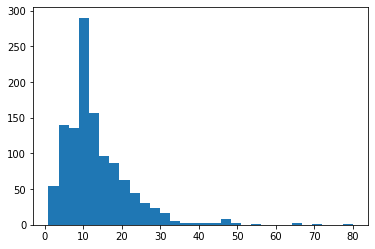

In [60]:
plt.hist(df.QTY,bins=30)
plt.show()

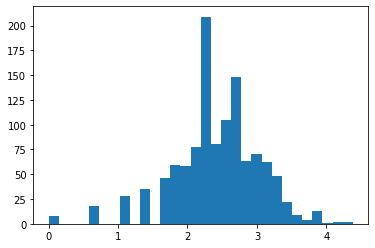

In [109]:
plt.hist(np.log(df.QTY),bins=30)
plt.show()

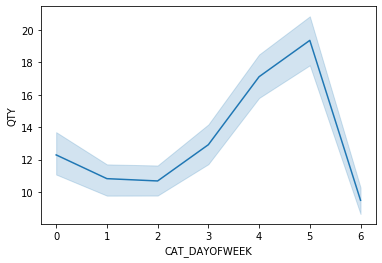

In [64]:
sns.lineplot(x="CAT_DAYOFWEEK", y="QTY", data=df)

Looks like we're selling the most on saturday.

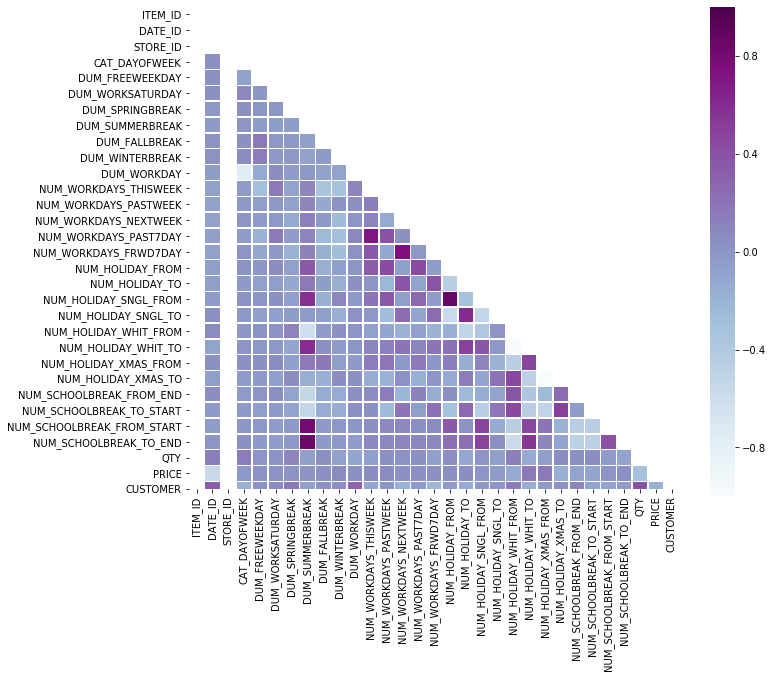

In [66]:
# Compute the correlation matrix 
corr_all = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_all, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize = (11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_all, mask = mask, square = True, linewidths = .5, ax = ax, cmap = "BuPu")      
plt.show()

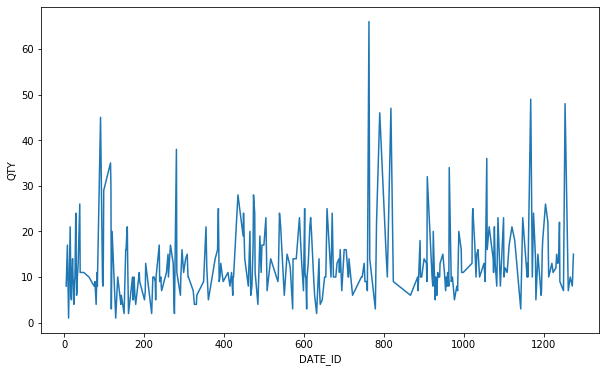

In [106]:
plt.figure(figsize = (10, 6))
sns.lineplot(x="DATE_ID", y="QTY", data=df.sample(frac=0.25))
plt.show()

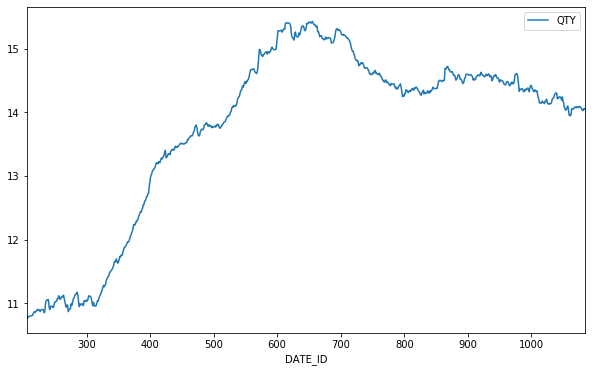

In [104]:
plt.figure(figsize = (10, 6))
decomposition = seasonal_decompose(df[['DATE_ID','QTY']], model = 'additive', freq = 365)
decomposition.trend.plot(x='DATE_ID',y='QTY',ax = plt.gca())
plt.show()

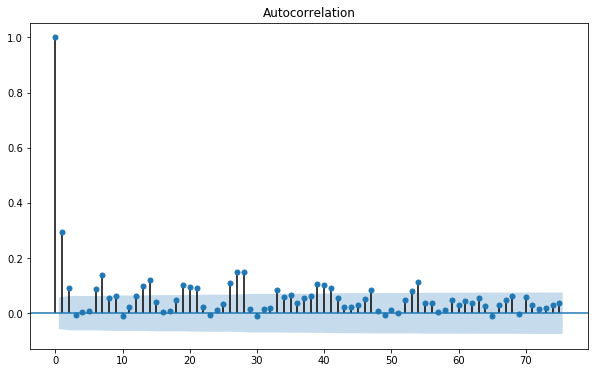

In [102]:
plt.figure(figsize = (10, 6))
plot_acf(df.QTY, lags = 75, ax = plt.gca());

Looks like observations are often correlated to previous observations.

## Modeling

In [110]:
list(df.keys())

['ITEM_ID',
 'DATE_ID',
 'STORE_ID',
 'CAT_DAYOFWEEK',
 'DUM_FREEWEEKDAY',
 'DUM_WORKSATURDAY',
 'DUM_SPRINGBREAK',
 'DUM_SUMMERBREAK',
 'DUM_FALLBREAK',
 'DUM_WINTERBREAK',
 'DUM_WORKDAY',
 'NUM_WORKDAYS_THISWEEK',
 'NUM_WORKDAYS_PASTWEEK',
 'NUM_WORKDAYS_NEXTWEEK',
 'NUM_WORKDAYS_PAST7DAY',
 'NUM_WORKDAYS_FRWD7DAY',
 'NUM_HOLIDAY_FROM',
 'NUM_HOLIDAY_TO',
 'NUM_HOLIDAY_SNGL_FROM',
 'NUM_HOLIDAY_SNGL_TO',
 'NUM_HOLIDAY_WHIT_FROM',
 'NUM_HOLIDAY_WHIT_TO',
 'NUM_HOLIDAY_XMAS_FROM',
 'NUM_HOLIDAY_XMAS_TO',
 'NUM_SCHOOLBREAK_FROM_END',
 'NUM_SCHOOLBREAK_TO_START',
 'NUM_SCHOOLBREAK_FROM_START',
 'NUM_SCHOOLBREAK_TO_END',
 'QTY',
 'PRICE',
 'CUSTOMER']

In [119]:
# Exclude: 
# - ID's, 
# - NANs
# - what we can't know at prediction time 
features = [col for col in list(df.keys()) if (col not in list(df.keys())[:3]) & \
                                              (col not in ['NUM_HOLIDAY_WHIT_TO', 'QTY', 'CUSTOMER'])]
features

['CAT_DAYOFWEEK',
 'DUM_FREEWEEKDAY',
 'DUM_WORKSATURDAY',
 'DUM_SPRINGBREAK',
 'DUM_SUMMERBREAK',
 'DUM_FALLBREAK',
 'DUM_WINTERBREAK',
 'DUM_WORKDAY',
 'NUM_WORKDAYS_THISWEEK',
 'NUM_WORKDAYS_PASTWEEK',
 'NUM_WORKDAYS_NEXTWEEK',
 'NUM_WORKDAYS_PAST7DAY',
 'NUM_WORKDAYS_FRWD7DAY',
 'NUM_HOLIDAY_FROM',
 'NUM_HOLIDAY_TO',
 'NUM_HOLIDAY_SNGL_FROM',
 'NUM_HOLIDAY_SNGL_TO',
 'NUM_HOLIDAY_WHIT_FROM',
 'NUM_HOLIDAY_XMAS_FROM',
 'NUM_HOLIDAY_XMAS_TO',
 'NUM_SCHOOLBREAK_FROM_END',
 'NUM_SCHOOLBREAK_TO_START',
 'NUM_SCHOOLBREAK_FROM_START',
 'NUM_SCHOOLBREAK_TO_END',
 'PRICE']

Before we start splitting our data set, we first exclude the last month. We can compare it with our designed model later.

In [124]:
df_new_data = df[-30:]
df = df.drop(df_new_data.index)

In [158]:
seed = 20191102
y = df.QTY #np.log(df.QTY)
X = df
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = seed)

In [141]:
# def rmspe(y, yhat):
#     return np.sqrt(np.mean((yhat / y-1) ** 2))

# def rmspe_xg(yhat, y):
#     y = np.expm1(y.get_label())
#     yhat = np.expm1(yhat)
#     return "rmspe", rmspe(y, yhat)

def amse(y, yhat):
    "Returns Absolute Mean Squared Error"
    return 'amse', np.average(np.abs(yhat - y))

In [159]:
# base parameters
params = {
    'booster': 'gbtree', 
    'objective': 'reg:squarederror', # regression task
    'subsample': 0.8, # 80% of data to grow trees and prevent overfitting
    'colsample_bytree': 0.85, # 85% of features used
    'eta': 0.1, 
    'max_depth': 10, 
    'seed': seed} # for reproducible results

In [160]:
dtrain = xgb.DMatrix(X_train[features], y_train)
dtest = xgb.DMatrix(X_test[features], y_test)

watchlist = [(dtrain, 'train'), (dtest, 'test')]

xgb_model = xgb.train(params, dtrain, 300, 
                      evals = watchlist,
                      early_stopping_rounds = 40
#                       feval = amse, 
#                       verbose_eval = True
                     )

[0]	train-rmse:14.4183	test-rmse:14.4808
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 40 rounds.
[1]	train-rmse:13.2726	test-rmse:13.4164
[2]	train-rmse:12.246	test-rmse:12.4329
[3]	train-rmse:11.3302	test-rmse:11.5915
[4]	train-rmse:10.5039	test-rmse:10.8716
[5]	train-rmse:9.77177	test-rmse:10.301
[6]	train-rmse:9.10765	test-rmse:9.75456
[7]	train-rmse:8.5149	test-rmse:9.28048
[8]	train-rmse:7.96216	test-rmse:8.86241
[9]	train-rmse:7.48854	test-rmse:8.50833
[10]	train-rmse:7.02883	test-rmse:8.1986
[11]	train-rmse:6.65524	test-rmse:7.95807
[12]	train-rmse:6.30382	test-rmse:7.77546
[13]	train-rmse:5.98361	test-rmse:7.60134
[14]	train-rmse:5.65924	test-rmse:7.46054
[15]	train-rmse:5.40726	test-rmse:7.34952
[16]	train-rmse:5.1982	test-rmse:7.27132
[17]	train-rmse:4.97522	test-rmse:7.16378
[18]	train-rmse:4.74205	test-rmse:7.10485
[19]	train-rmse:4.56773	test-rmse:7.06783
[20]	train-rmse:4.39505	test-rms

In [161]:
#Trying sklearn
params_sk = {'max_depth': 10, 
            'n_estimators': 300, # the same as num_rounds in xgboost
            'objective': 'reg:squarederror', 
            'subsample': 0.8, 
            'colsample_bytree': 0.85, 
            'learning_rate': 0.1, 
            'seed': seed}     

skrg = XGBRegressor(**params_sk)

skrg.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.85, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=None, n_estimators=300,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=20191102, silent=None, subsample=0.8, verbosity=1)

In [162]:
import scipy.stats as st

params_grid = {  
    'learning_rate': st.uniform(0.01, 0.3), # eta in xgb package
    'max_depth': list(range(10, 20, 2)),
    'gamma': st.uniform(0, 10),
    'reg_alpha': st.expon(0, 50)}

search_sk = RandomizedSearchCV(skrg, params_grid, cv = 5) # 5 fold cross validation
search_sk.fit(X_train, y_train)

# best parameters
print(search_sk.best_params_); print(search_sk.best_score_)

{'gamma': 7.109043996566592, 'learning_rate': 0.2050643049691398, 'max_depth': 18, 'reg_alpha': 14.619255436000431}
0.9866083446782186


In [163]:
# with new parameters
params_new = {
    'booster': 'gbtree', 
    'objective': 'reg:squarederror', 
    'subsample': 0.8, 
    'colsample_bytree': 0.85, 
    'eta': 0.2050643049691398, 
    'max_depth': 18, 
    'gamma': 7.109043996566592,
    'reg_alpha': 14.619255436000431,
    'seed': seed} 

model_final = xgb.train(params_new, dtrain, 300, evals = watchlist,
                        early_stopping_rounds = 40, 
#                         feval = rmspe_xg, 
                        verbose_eval = True)

[0]	train-rmse:13.3257	test-rmse:13.402
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 40 rounds.
[1]	train-rmse:11.4295	test-rmse:11.53
[2]	train-rmse:9.9055	test-rmse:10.1962
[3]	train-rmse:8.73765	test-rmse:9.1996
[4]	train-rmse:7.85961	test-rmse:8.54274
[5]	train-rmse:7.16215	test-rmse:8.10757
[6]	train-rmse:6.66854	test-rmse:7.80837
[7]	train-rmse:6.20085	test-rmse:7.6463
[8]	train-rmse:5.77088	test-rmse:7.4611
[9]	train-rmse:5.45917	test-rmse:7.37017
[10]	train-rmse:5.15152	test-rmse:7.30503
[11]	train-rmse:4.87648	test-rmse:7.23141
[12]	train-rmse:4.64786	test-rmse:7.13403
[13]	train-rmse:4.44388	test-rmse:7.08478
[14]	train-rmse:4.22316	test-rmse:7.04289
[15]	train-rmse:4.09155	test-rmse:7.02827
[16]	train-rmse:3.97142	test-rmse:7.04198
[17]	train-rmse:3.85114	test-rmse:7.0202
[18]	train-rmse:3.74269	test-rmse:7.02675
[19]	train-rmse:3.63082	test-rmse:6.99009
[20]	train-rmse:3.54071	test-rmse:6

Slightly less overfitting, but its performance is still bad.

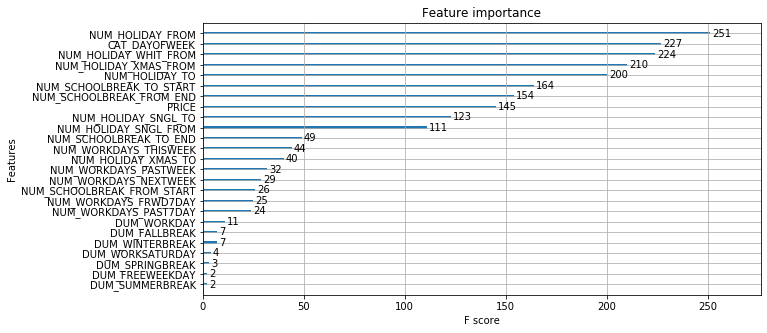

In [169]:
fig, ax = plt.subplots(figsize=(10, 5))
xgb.plot_importance(model_final,ax=ax)
plt.show()

In [186]:
from sklearn.ensemble import RandomForestRegressor

In [187]:
regr = RandomForestRegressor()
regr.fit(X_train[features],y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [189]:
# regr.predict(X_train[features][:2])

array([43.8, 24.3])

In [193]:
amse(y_train, regr.predict(X_train[features]))

('amse', 1.9813048933500625)

In [196]:
amse(y_test, regr.predict(X_test[features]))

('amse', 5.138888888888889)

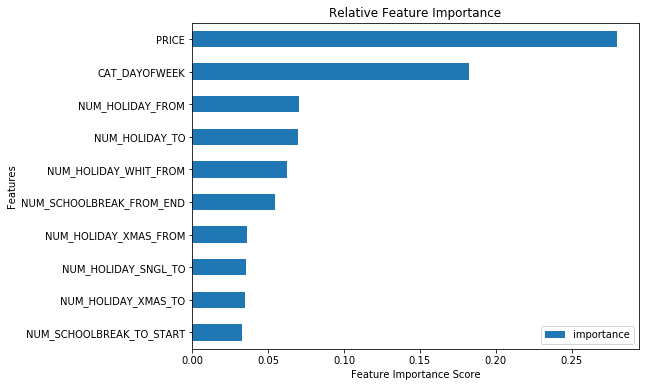

In [203]:
#plot importances
feat_imp = pd.DataFrame({'importance':regr.feature_importances_})    
feat_imp['Features'] = features
feat_imp.sort_values(by='importance', ascending=False, inplace=True)
feat_imp = feat_imp.iloc[:10]
    
feat_imp.sort_values(by='importance', inplace=True)
feat_imp = feat_imp.set_index('Features', drop=True)
feat_imp.plot.barh(title='Relative Feature Importance', figsize=(8,6))
plt.xlabel('Feature Importance Score')
plt.show()

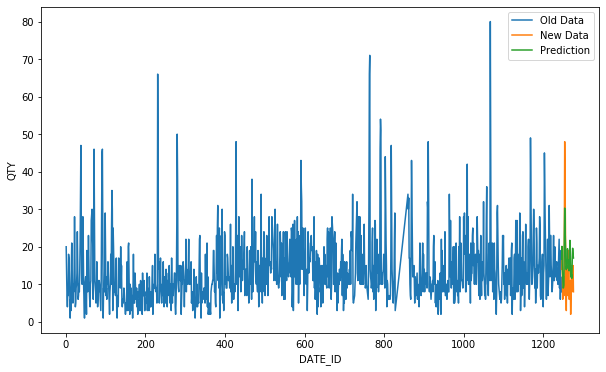

In [244]:
plt.figure(figsize=(10,6))
sns.lineplot(df.DATE_ID,df.QTY, label = "Old Data")
sns.lineplot(df_new_data[df_new_data.DATE_ID > 1000].DATE_ID,df_new_data[df_new_data.DATE_ID > 1000].QTY, label = "New Data")
sns.lineplot(df_new_data[df_new_data.DATE_ID > 1000].DATE_ID,regr.predict(df_new_data[df_new_data.DATE_ID > 1000][features]), label = "Prediction")

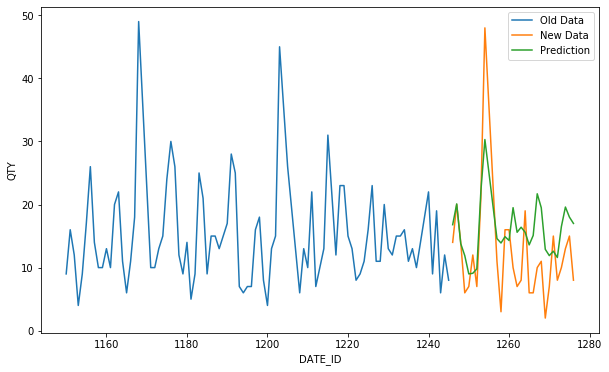

In [239]:
#zoom in
last_x_days = 90
plt.figure(figsize=(10,6))
sns.lineplot(df.DATE_ID[-last_x_days:],df.QTY[-last_x_days:], label = "Old Data")
sns.lineplot(df_new_data[df_new_data.DATE_ID > 1000].DATE_ID,df_new_data[df_new_data.DATE_ID > 1000].QTY, label = "New Data")
sns.lineplot(df_new_data[df_new_data.DATE_ID > 1000].DATE_ID,regr.predict(df_new_data[df_new_data.DATE_ID > 1000][features]), label = "Prediction")

For an untuned model the result doesn't look too bad. We see that roughly the first 14 days our predictions work quite well.

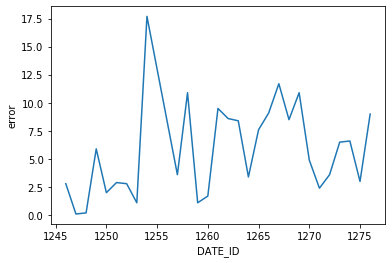

In [243]:
df_new_data['error'] = np.abs(regr.predict(df_new_data[features]) - df_new_data.QTY)
sns.lineplot(df_new_data[df_new_data.DATE_ID > 1000].DATE_ID,df_new_data[df_new_data.DATE_ID > 1000].error)
plt.show()

To be more precise, the first 7/8 days look fine in that case.

In [260]:
#Evaluate Model performance
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

base_model_rf = regr
base_accuracy = evaluate(base_model_rf, X_test[features], y_test)

Model Performance
Average Error: 5.1389 degrees.
Accuracy = 35.60%.


In [265]:
model_final_xbt = model_final
xbt_accuracy = evaluate(model_final_xbt, dtest, y_test)

Model Performance
Average Error: 4.7760 degrees.
Accuracy = 39.10%.


In [252]:
# Tuning
regr.get_params()

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [253]:
base_params = regr.get_params()

In [276]:
bootstrap = [True, False]
criterion = ['mse','mae']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
max_features = ['auto','sqrt','log2', None]
# max_leaf_nodes = 
# min_impurity_decrease
# min_impurity_split
min_samples_leaf = [int(x) for x in np.linspace(1, 10, num = 10)]
min_samples_split =[int(x) for x in np.linspace(2, 10, num = 9)]
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

params_grid = { 
    'bootstrap': bootstrap,
    'criterion': criterion,
    'max_depth': max_depth,
    'max_features': max_features,
    'min_samples_leaf': min_samples_leaf,
    'min_samples_split': min_samples_split,
    'n_estimators': n_estimators
}
params_grid                

{'bootstrap': [True, False],
 'criterion': ['mse', 'mae'],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt', 'log2', None],
 'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

In [277]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()

# Random search of parameters, using 5 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = params_grid, 
                               n_iter = 100, 
                               cv = 5, 
                               verbose=2, 
                               random_state=seed, 
                               n_jobs = -1)

# Fit the random search model
rf_random.fit(X_train[features],y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 11.0min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=None, oob_score=False,
                                                   random_sta...


In [279]:
rf_random.best_params_

{'n_estimators': 200,
 'min_samples_split': 7,
 'min_samples_leaf': 5,
 'max_features': None,
 'max_depth': 10,
 'criterion': 'mse',
 'bootstrap': True}

In [280]:
random_model_rf = rf_random
random_accuracy = evaluate(random_model_rf, X_test[features], y_test)

Model Performance
Average Error: 4.6899 degrees.
Accuracy = 40.44%.


In [297]:
# Deep Dive GridSearch
bootstrap = [True]
criterion = ['mse']
max_depth = [int(x) for x in np.linspace(5, 15, num = 11)]
max_features = [None]
min_samples_leaf = [int(x) for x in np.linspace(2, 8, num = 7)]
min_samples_split =[int(x) for x in np.linspace(4, 9, num = 6)]
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 500, num = 6)]

params_grid_2 = { 
    'bootstrap': bootstrap,
    'criterion': criterion,
    'max_depth': max_depth,
    'max_features': max_features,
    'min_samples_leaf': min_samples_leaf,
    'min_samples_split': min_samples_split,
    'n_estimators': n_estimators
}
params_grid_2

{'bootstrap': [True],
 'criterion': ['mse'],
 'max_depth': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
 'max_features': [None],
 'min_samples_leaf': [2, 3, 4, 5, 6, 7, 8],
 'min_samples_split': [4, 5, 6, 7, 8, 9],
 'n_estimators': [50, 140, 230, 320, 410, 500]}

In [298]:
rf = RandomForestRegressor()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = params_grid_2, 
                          cv = 5, n_jobs = -1, verbose = 2)

grid_search.fit(X_train[features],y_train)
grid_search.best_params_

Fitting 5 folds for each of 2772 candidates, totalling 13860 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:   40.2s
[Parallel(n_jobs=-1)]: Done 989 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1434 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1961 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 2568 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 3257 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 4877 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 5808 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 6821 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done 7914 tasks      | elapsed: 12.2min
[Parallel(n_jobs=-1)]: Done 9089 tasks      | 

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': 7,
 'max_features': None,
 'min_samples_leaf': 4,
 'min_samples_split': 8,
 'n_estimators': 50}

In [299]:
rf_optimal = RandomForestRegressor(bootstrap = True,
                                   criterion = 'mse',
                                   max_depth = 7,
                                   max_features = None,
                                   min_samples_leaf = 4,
                                   min_samples_split = 8,
                                   n_estimators = 50)
rf_optimal.fit(X_train[features],y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=7,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=4, min_samples_split=8,
                      min_weight_fraction_leaf=0.0, n_estimators=50,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [301]:
opt_model_rf = rf_optimal
opt_random_accuracy = evaluate(opt_model_rf, X_test[features], y_test)

Model Performance
Average Error: 4.6336 degrees.
Accuracy = 39.89%.


Our improworsening was a success. However, lets see how the models perform on new data.

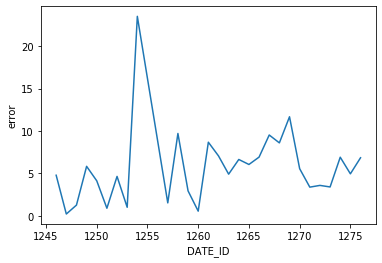

In [302]:
df_new_data['error'] = np.abs(random_model_rf.predict(df_new_data[features]) - df_new_data.QTY)
sns.lineplot(df_new_data[df_new_data.DATE_ID > 1000].DATE_ID,df_new_data[df_new_data.DATE_ID > 1000].error)
plt.show()

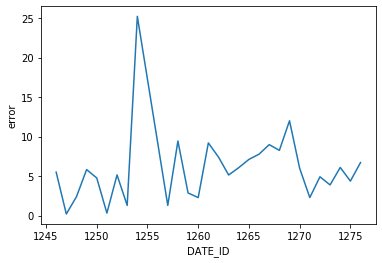

In [303]:
df_new_data['error'] = np.abs(opt_model_rf.predict(df_new_data[features]) - df_new_data.QTY)
sns.lineplot(df_new_data[df_new_data.DATE_ID > 1000].DATE_ID,df_new_data[df_new_data.DATE_ID > 1000].error)
plt.show()

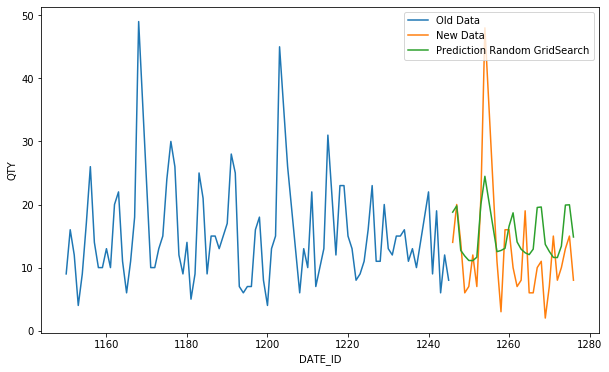

In [304]:
last_x_days = 90
plt.figure(figsize=(10,6))
sns.lineplot(df.DATE_ID[-last_x_days:],df.QTY[-last_x_days:], label = "Old Data")
sns.lineplot(df_new_data[df_new_data.DATE_ID > 1000].DATE_ID,df_new_data[df_new_data.DATE_ID > 1000].QTY, label = "New Data")
sns.lineplot(df_new_data[df_new_data.DATE_ID > 1000].DATE_ID,random_model_rf.predict(df_new_data[df_new_data.DATE_ID > 1000][features]), label = "Prediction Random GridSearch")

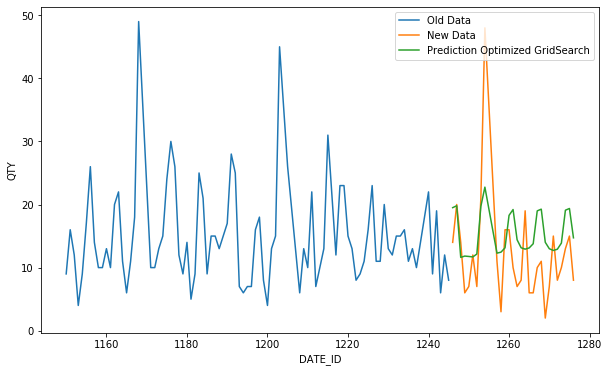

In [305]:
last_x_days = 90
plt.figure(figsize=(10,6))
sns.lineplot(df.DATE_ID[-last_x_days:],df.QTY[-last_x_days:], label = "Old Data")
sns.lineplot(df_new_data[df_new_data.DATE_ID > 1000].DATE_ID,df_new_data[df_new_data.DATE_ID > 1000].QTY, label = "New Data")
sns.lineplot(df_new_data[df_new_data.DATE_ID > 1000].DATE_ID,opt_model_rf.predict(df_new_data[df_new_data.DATE_ID > 1000][features]), label = "Prediction Optimized GridSearch")

It didn't get much better. But how is the accuracy, if we check the first 7 days?

In [314]:
evaluate(opt_model_rf, df_new_data[:7][features], df_new_data[:7].QTY)

Model Performance
Average Error: 3.4488 degrees.
Accuracy = 57.32%.


57.324716473137414

In [315]:
evaluate(random_model_rf, df_new_data[:7][features], df_new_data[:7].QTY)

Model Performance
Average Error: 3.1116 degrees.
Accuracy = 60.79%.


60.78749971611962

In [316]:
evaluate(base_model_rf, df_new_data[:7][features], df_new_data[:7].QTY)

Model Performance
Average Error: 2.3857 degrees.
Accuracy = 69.57%.


69.57142857142857

In [317]:
dtest_new = xgb.DMatrix(df_new_data[:7][features], df_new_data[:7].QTY)
evaluate(model_final_xbt, dtest_new, df_new_data[:7].QTY)

Model Performance
Average Error: 3.0264 degrees.
Accuracy = 59.92%.


59.92260511229638

It looks like our base random forest outperformed on new data. That might not be representative, though.